# Velocity profiles

In [1]:
# Librerías estándar y de terceros
import os
import sys
import gc
import ast
import math as m
import numpy as np
import scipy
import pandas as pd
from scipy import *
from matplotlib.cm import viridis
from matplotlib.colors import Normalize
from scipy.signal import butter, filtfilt, hilbert
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np
import pylab
import matplotlib.pyplot as plt
params = {'legend.fontsize': 'x-Large',
          'figure.figsize': (11, 6),
         'axes.labelsize': 33,
         'axes.titlesize':33,
         'xtick.labelsize':30,
         'ytick.labelsize':30,
    'font.family': 'STIXGeneral',  # Use 'Comic Sans MS' or 'Helvetica' here as needed
    'axes.titleweight': 'normal',
    'axes.labelweight': 'normal',
    'text.usetex': True, # Enable LaTeX rendering
}

pylab.rcParams.update(params)
# Configuración de rutas para importaciones personalizadas
#sys.path.append('/projects/DEIKE/cmartinb/jupyter_notebook/project_specific/turbulence')
sys.path.append('/projects/DEIKE/cmartinb/functions')

# Funciones y clases personalizadas
from prepare import load_object, save_object, field
from defs import Case, Interface2D
from phase import extract_phase
from funciones import *  # Asegúrate de que la importación con * sea necesaria, a veces es mejor importar solo las funciones necesarias

os.chdir('/projects/DEIKE/cmartinb/')

In [2]:
# DEFINE CASE SO WE CAN AUTHOMATIZE IT 
kpHs = '0p16' # 0p16 0p08
uoc = '0p25' # 0p25 0p75 0p50

#Common parameters 
kp = 4
u = 0.5
lambdap = 2*m.pi/kp
Re_water = 2.5 * 10**4

In [3]:
def calculate_parameters(kpHs, uoc):
    # Convert kpHs and uoc to their numeric values
    ak = float(kpHs.replace('p', '.'))
    uoc_val = float(uoc.replace('p', '.'))

    # Determine the value of g based on uoc
    if uoc_val == 0.50:
        g = 1
    elif uoc_val == 0.25:
        g = 4
    elif uoc_val == 0.75:
        g = 0.5
    else:
        raise ValueError("uoc value not recognized. Please use 0p25, 0p50, or 0p75.")
    
    c = u / uoc_val
    omegap = np.sqrt(g * kp)
    Re_water = 2.5 * 10**4
    nu_water = c * 2 * m.pi / (4 * Re_water)

    return ak, c, omegap, nu_water, g, uoc_val

In [4]:
ak, c, omegap, nu_water, g , uoc_val= calculate_parameters(kpHs, uoc)
print('ak is', ak, 'c is' ,c, 'w_p$ is', omegap, '$\nu_w$ is' , nu_water, 'g is' ,g)

ak is 0.16 c is 2.0 w_p$ is 4.0 $
u_w$ is 0.0001256637061435917 g is 4


In [5]:
work_dir = f'/projects/DEIKE/nscapin/broadband/kpHs{kpHs}_uoc{uoc}/'
data = np.loadtxt(work_dir+'profiles/log_pro.out')

istep_c_vel =data[:, 1]
time_vel = data[:,0] 
print((time_vel-time_vel[0])* omegap / (2 * np.pi))

[ 0.          0.06250002  0.12499997  0.18749999  0.25000001  0.31250003
  0.37499999  0.4375      0.50000002  0.56249998  0.625       0.68750002
  0.74999997  0.81249999  0.87500001  0.93750003  0.99999998  1.0625
  1.12500002  1.18749998  1.24999999  1.31250001  1.37499997  1.43749999
  1.50000001  1.56250003  1.62499998  1.6875      1.75000002  1.81249997
  1.87499999  1.93750001  2.00000003  2.06249998  2.125       2.18750002
  2.24999998  2.3125      2.37500002  2.43749997  2.49999999  2.56250001
  2.62500003  2.68749998  2.75        2.81250002  2.87499997  2.93749999
  3.00000001  3.06250003  3.12499999  3.18750001  3.25000002  3.31249998
  3.375       3.43750002  3.49999997  3.56249999  3.62500001  3.68750003
  3.74999998  3.8125      3.87500002  3.93749998  4.          4.06250001
  4.12499997  4.18749999  4.25000001  4.31250003  4.37499998  4.4375
  4.50000002  4.56249997  4.62499999  4.68750001  4.75000003  4.81249999
  4.875       4.93750002  4.99999998  5.0625      5.1250000

In [6]:
#phi    u.x     u.y     u.z     p       omega   uv      duy     diss    ke      vke     dkdy 

In [7]:
# Define the filename to save
save_filename = f'/projects/DEIKE/cmartinb/processed_profiles/processed_profiles_kpHs{kpHs}_uoc{uoc}.csv'

# Check if the file already exists
if not os.path.exists(save_filename):
    # Log file name
    log_filename = work_dir + 'profiles/log_pro.out'
    data_field = np.loadtxt(log_filename)

    # Define the columns of the DataFrame
    columns = ['time', 'istep', 'phi', 'u.x', 'u.y', 'u.z', 'p', 'omega', 'uv', 'duy', 'diss', 'ke', 'vke', 'dkdy']

    # Initialize an empty list to store the data
    all_profiles = []

    # Loop through the step indices
    for idx, row in enumerate(data_field):
        time_step = row[0]
        istep = int(row[1])

        # Read the corresponding profile file
        filename = work_dir + f'profiles/prof_{istep:09}.out'
        profile_data = np.loadtxt(filename)

        # Assume 'profile_data' has the shape (M, 14), where M is the number of measurements
        # Create a dictionary with the data for this time step, each entry of the dictionary will be a vector
        profile_dict = {'time': time_step, 'istep': istep}
        for col_idx, col_name in enumerate(columns[2:]):  # Start at 2 to skip 'time' and 'istep'
            profile_dict[col_name] = profile_data[:, col_idx].tolist()  # Convert to list to avoid issues with pandas

        all_profiles.append(profile_dict)

    # Convert the list of dictionaries into a DataFrame
    profiles_df = pd.DataFrame(all_profiles)

    # Save the DataFrame as a CSV file
    profiles_df.to_csv(save_filename, index=False)
else:
    # Load the DataFrame from the existing CSV file
    profiles_df = pd.read_csv(save_filename)
    print(f"The file {save_filename} already exists. DataFrame loaded from the file.")


The file /projects/DEIKE/cmartinb/processed_profiles/processed_profiles_kpHs0p16_uoc0p25.csv already exists. DataFrame loaded from the file.


In [8]:
# Define the columns of the DataFrame
columns = ['time', 'istep', 'phi', 'u.x', 'u.y', 'u.z', 'p', 'omega', 'uv', 'duy', 'diss', 'ke', 'vke', 'dkdy']

In [9]:
tstart_vel = time_vel[0]

indice = np.argmax(omegap * (time_vel - tstart_vel) > 10)
# Filtra el DataFrame a partir del índice encontrado
profiles_df_trimmed = profiles_df.iloc[indice:].reset_index(drop=True)

# Puedes verificar la forma de los datos recortados si quieres
print(profiles_df_trimmed.shape)

# Guarda el DataFrame recortado si es necesario
profiles_df_trimmed.to_csv('/projects/DEIKE/cmartinb/processed_profiles/processed_profiles_kpHs{kpHs}_uoc{uoc}_trimmed.csv', index=False)

# Si quieres actualizar el DataFrame original
profiles_df = profiles_df_trimmed


(553, 14)


In [10]:
tstart_vel = profiles_df['time'][0]

Try to divide interval time like the otehr time interval for spectra study

In [11]:
#print((profiles_df['time']-tstart)* omegap / (2 * np.pi))
vector = np.array(profiles_df['time']-tstart_vel)* omegap / (2 * np.pi)
print(vector)

[ 0.          0.06250002  0.12500004  0.18749999  0.25000001  0.31250003
  0.37500005  0.4375      0.50000002  0.56250004  0.625       0.68750002
  0.75000003  0.81249999  0.87500001  0.93750003  1.00000005  1.0625
  1.12500002  1.18750004  1.24999999  1.31250001  1.37500003  1.43750005
  1.50000001  1.56250003  1.62500004  1.6875      1.75000002  1.81250004
  1.87499999  1.93750001  2.00000003  2.06250005  2.125       2.18750002
  2.25000004  2.3125      2.37500002  2.43750003  2.49999999  2.56250001
  2.62500003  2.68750005  2.75        2.81250002  2.87500004  2.93749999
  3.00000001  3.06250003  3.12500005  3.18750001  3.25000002  3.31250004
  3.375       3.43750002  3.50000004  3.56249999  3.62500001  3.68750003
  3.75000005  3.8125      3.87500002  3.93750004  4.          4.06250001
  4.12500003  4.18749999  4.25000001  4.31250003  4.37500004  4.4375
  4.50000002  4.56250004  4.62499999  4.68750001  4.75000003  4.81250005
  4.875       4.93750002  5.00000004  5.0625      5.1250000

In [12]:
tstart_vel = profiles_df['time'].iloc[0]
omegap = np.sqrt(1 * 4)

# Calcular los valores normalizados
time_normalized =(profiles_df['time']-tstart_vel)* omegap / (2 * np.pi)

# Imprimir el resultado completo
print(time_normalized)

# Encontrar el índice del valor más cercano a 4.66
target = 4.66 #2T0
idx_closest = np.argmin(np.abs(time_normalized - target))

# Definir la longitud del primer intervalo
interval_length = time_normalized.iloc[idx_closest]

# Crear una lista para almacenar los intervalos
intervals = []

# Inicializar el primer intervalo
start_idx = 0
end_idx = idx_closest
intervals.append((start_idx, end_idx))

# Crear los intervalos restantes con solapamiento de 0.5
overlap = 0.5
while end_idx < len(time_normalized) - 1:
    start_idx = end_idx - int(overlap / (time_normalized[1] - time_normalized[0]))
    end_idx = start_idx + idx_closest
    if end_idx >= len(time_normalized):
        end_idx = len(time_normalized) - 1
    intervals.append((start_idx, end_idx))

# Imprimir los intervalos
for i, (start, end) in enumerate(intervals):
    print(f"Interval {i + 1}: {time_normalized.iloc[start]:.4f} to {time_normalized.iloc[end]:.4f}")

# Restaurar la configuración por defecto de pandas
pd.reset_option('display.max_rows')


0       0.00000
1       0.03125
2       0.06250
3       0.09375
4       0.12500
         ...   
548    17.12500
549    17.15625
550    17.18750
551    17.21875
552    17.25000
Name: time, Length: 553, dtype: float64
Interval 1: 0.0000 to 4.6563
Interval 2: 4.1875 to 8.8438
Interval 3: 8.3750 to 13.0313
Interval 4: 12.5625 to 17.2187
Interval 5: 16.7500 to 17.2500


### Velocity in all the time interval

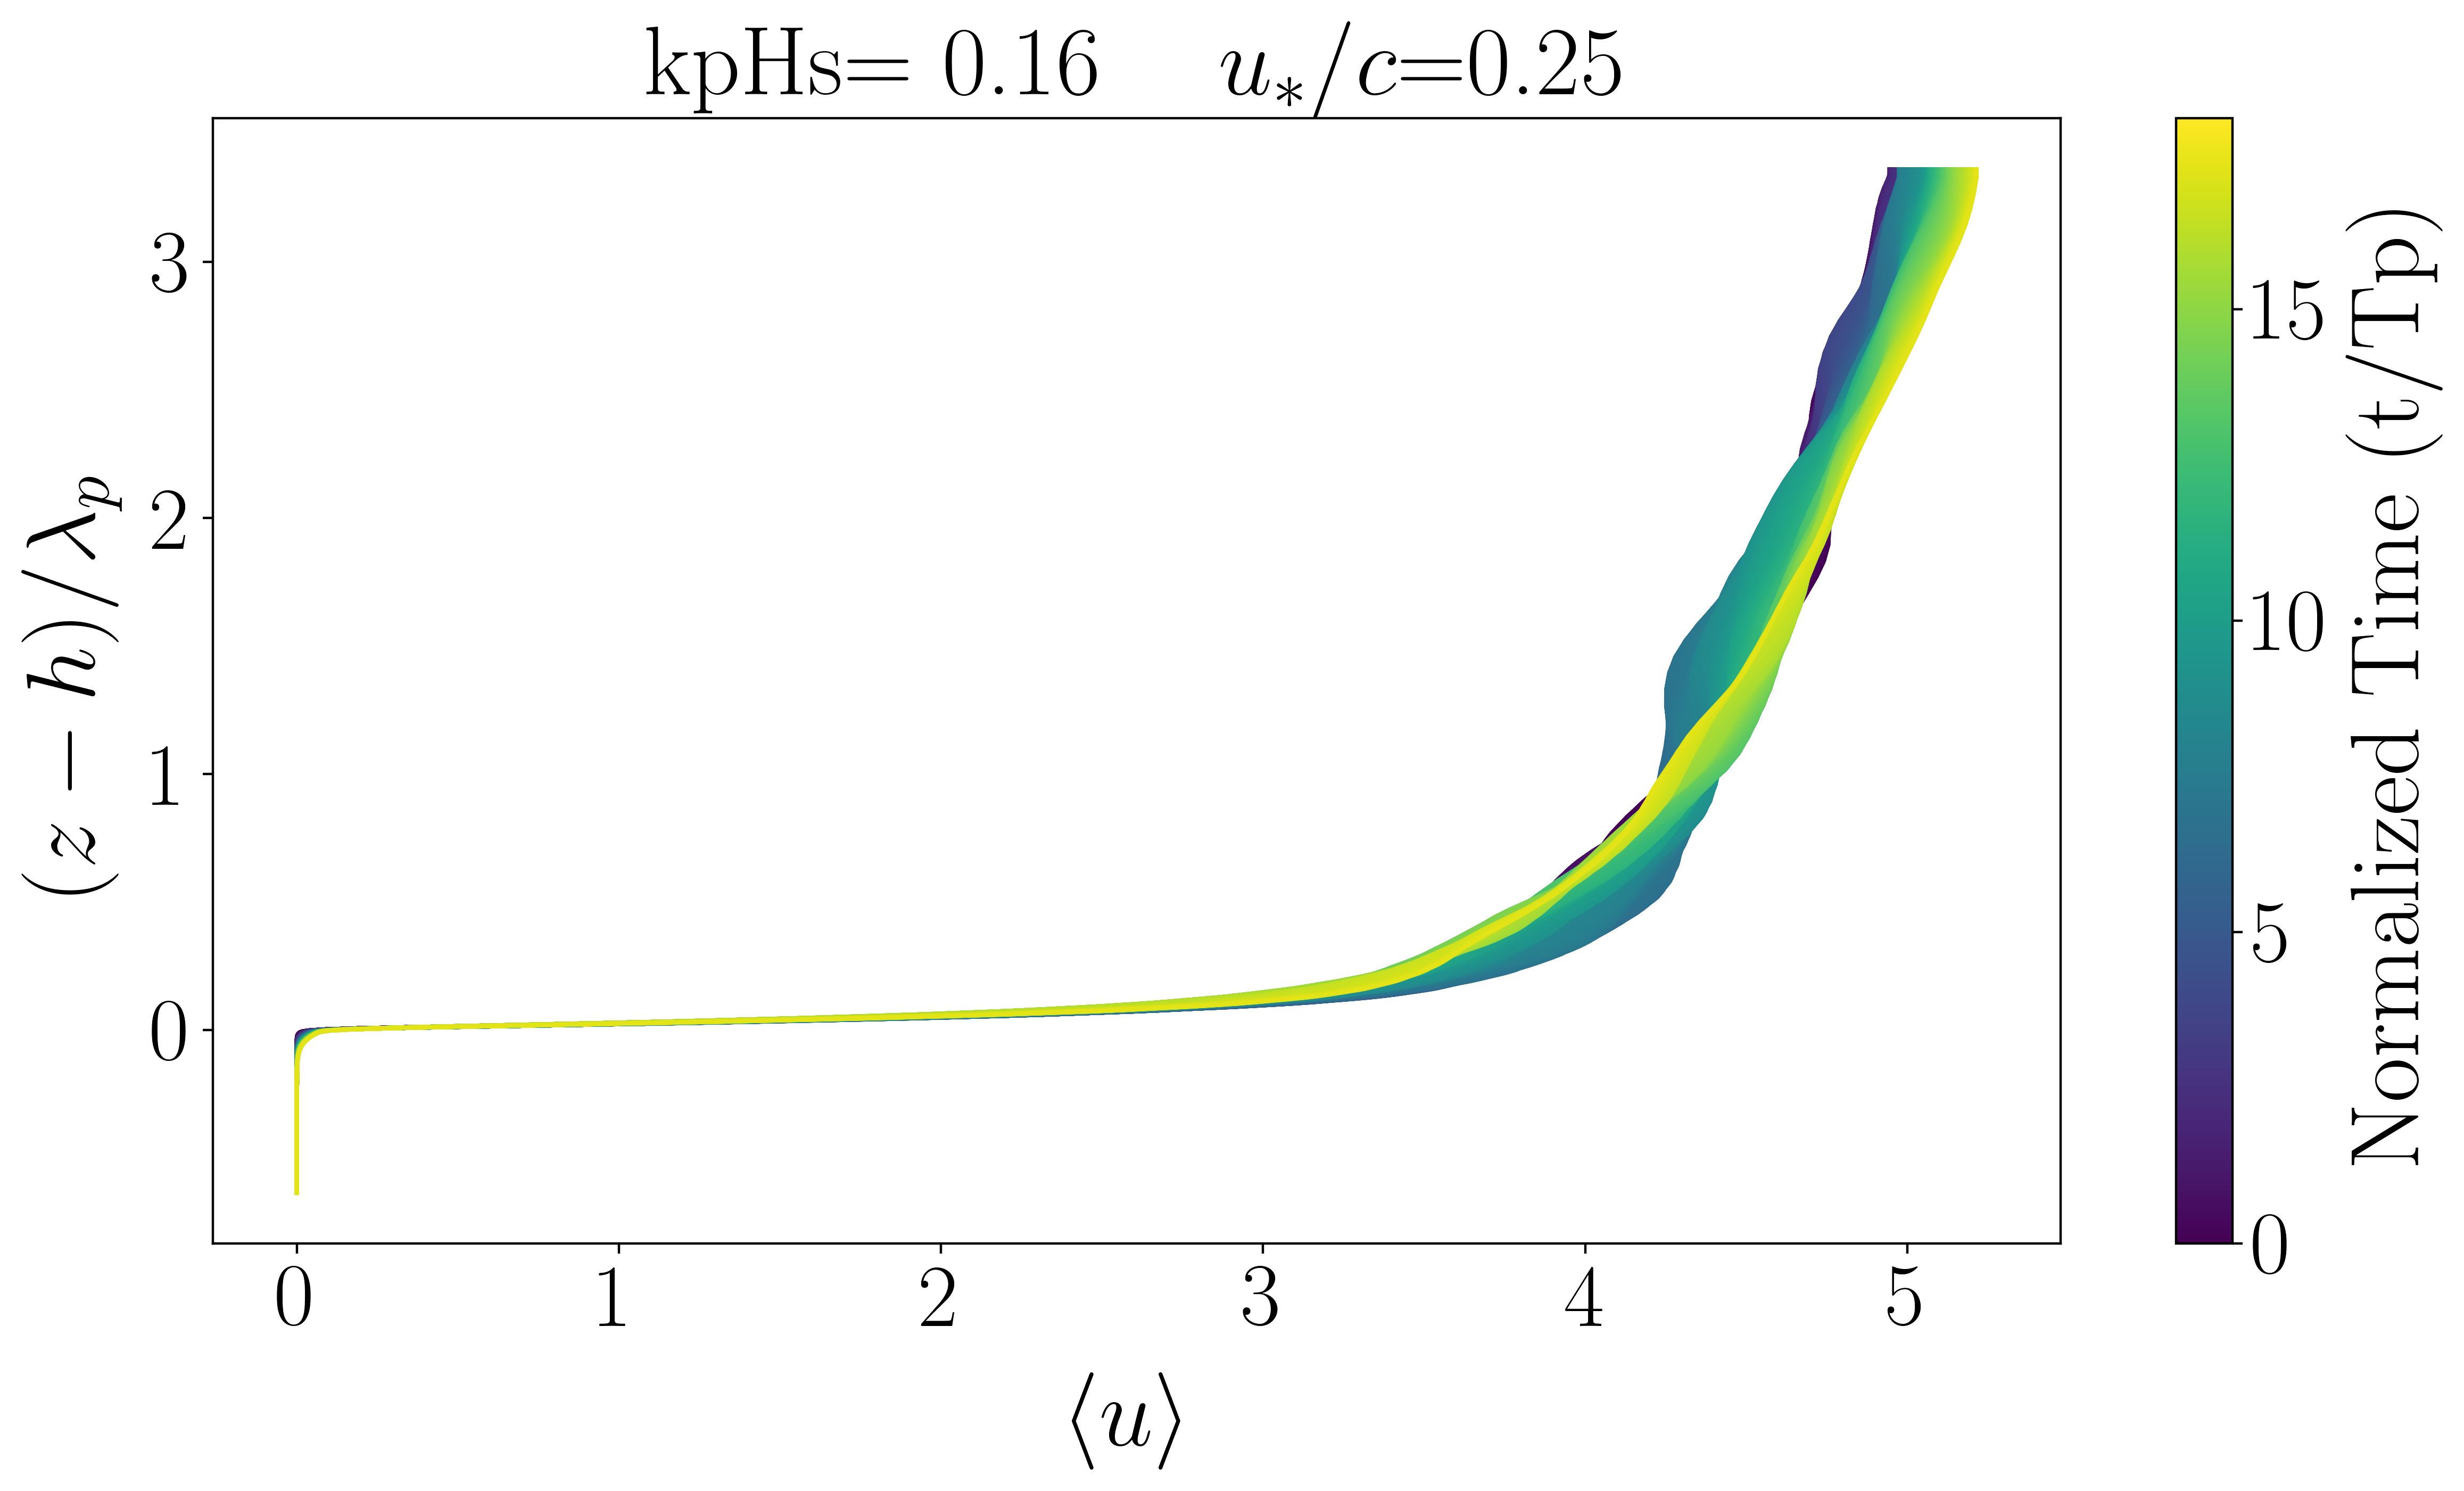

In [13]:
fig, ax = plt.subplots(figsize=[14, 7])
time_normalized = (time_vel - time_vel[0]) * omegap / (2 * np.pi)

# Normalizar el rango de tiempo para la colorbar basado en los valores normalizados
norm = Normalize(vmin=np.min(time_normalized), vmax=np.max(time_normalized))

# Crear un ScalarMappable para generar colores a partir de la paleta de colores
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array(time_normalized)  # Se pasa el array de tiempo normalizado para evitar errores

# Asegurarse de que el bucle no exceda el tamaño de 'time_normalized'
for i in range(min(len(profiles_df), len(time_normalized))):
    phi_str = profiles_df.at[i, 'phi']
    u_z_str = profiles_df.at[i, 'u.x']
    phi_array = np.array(ast.literal_eval(phi_str))
    u_z_array = np.array(ast.literal_eval(u_z_str))

    color = sm.to_rgba(time_normalized[i])
    norm = lambdap
    # Graficar con el color correspondiente
    ax.plot( u_z_array ,(phi_array-1)/norm,  color=color) #/ (0.25**1) 


# Añade la barra de colores a la figura.
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Normalized Time (t/Tp)')
#plt.axhline(y = 0.64, color = 'grey', linestyle = '--',lw=0.8) 

# Establecer escala logarítmica para el eje x
#plt.yscale('log')
#plt.xlim([0.64,6]) #air
#plt.ylim([0.7,4])  #air
#plt.xlim([-0.001,0.1]) #water
#plt.ylim([-0.64,0.1]) #water
#plt.yscale('log')
# Configura las etiquetas y el título
plt.ylabel(r'$(z-h)/\lambda_{p}$', labelpad = 10)
plt.xlabel(r'$\langle u\rangle$', labelpad = 10)
title_str = f'kpHs= {ak} \quad  $ u_\\ast/c$={uoc_val}'
ax.set_title(title_str)
plt.show()

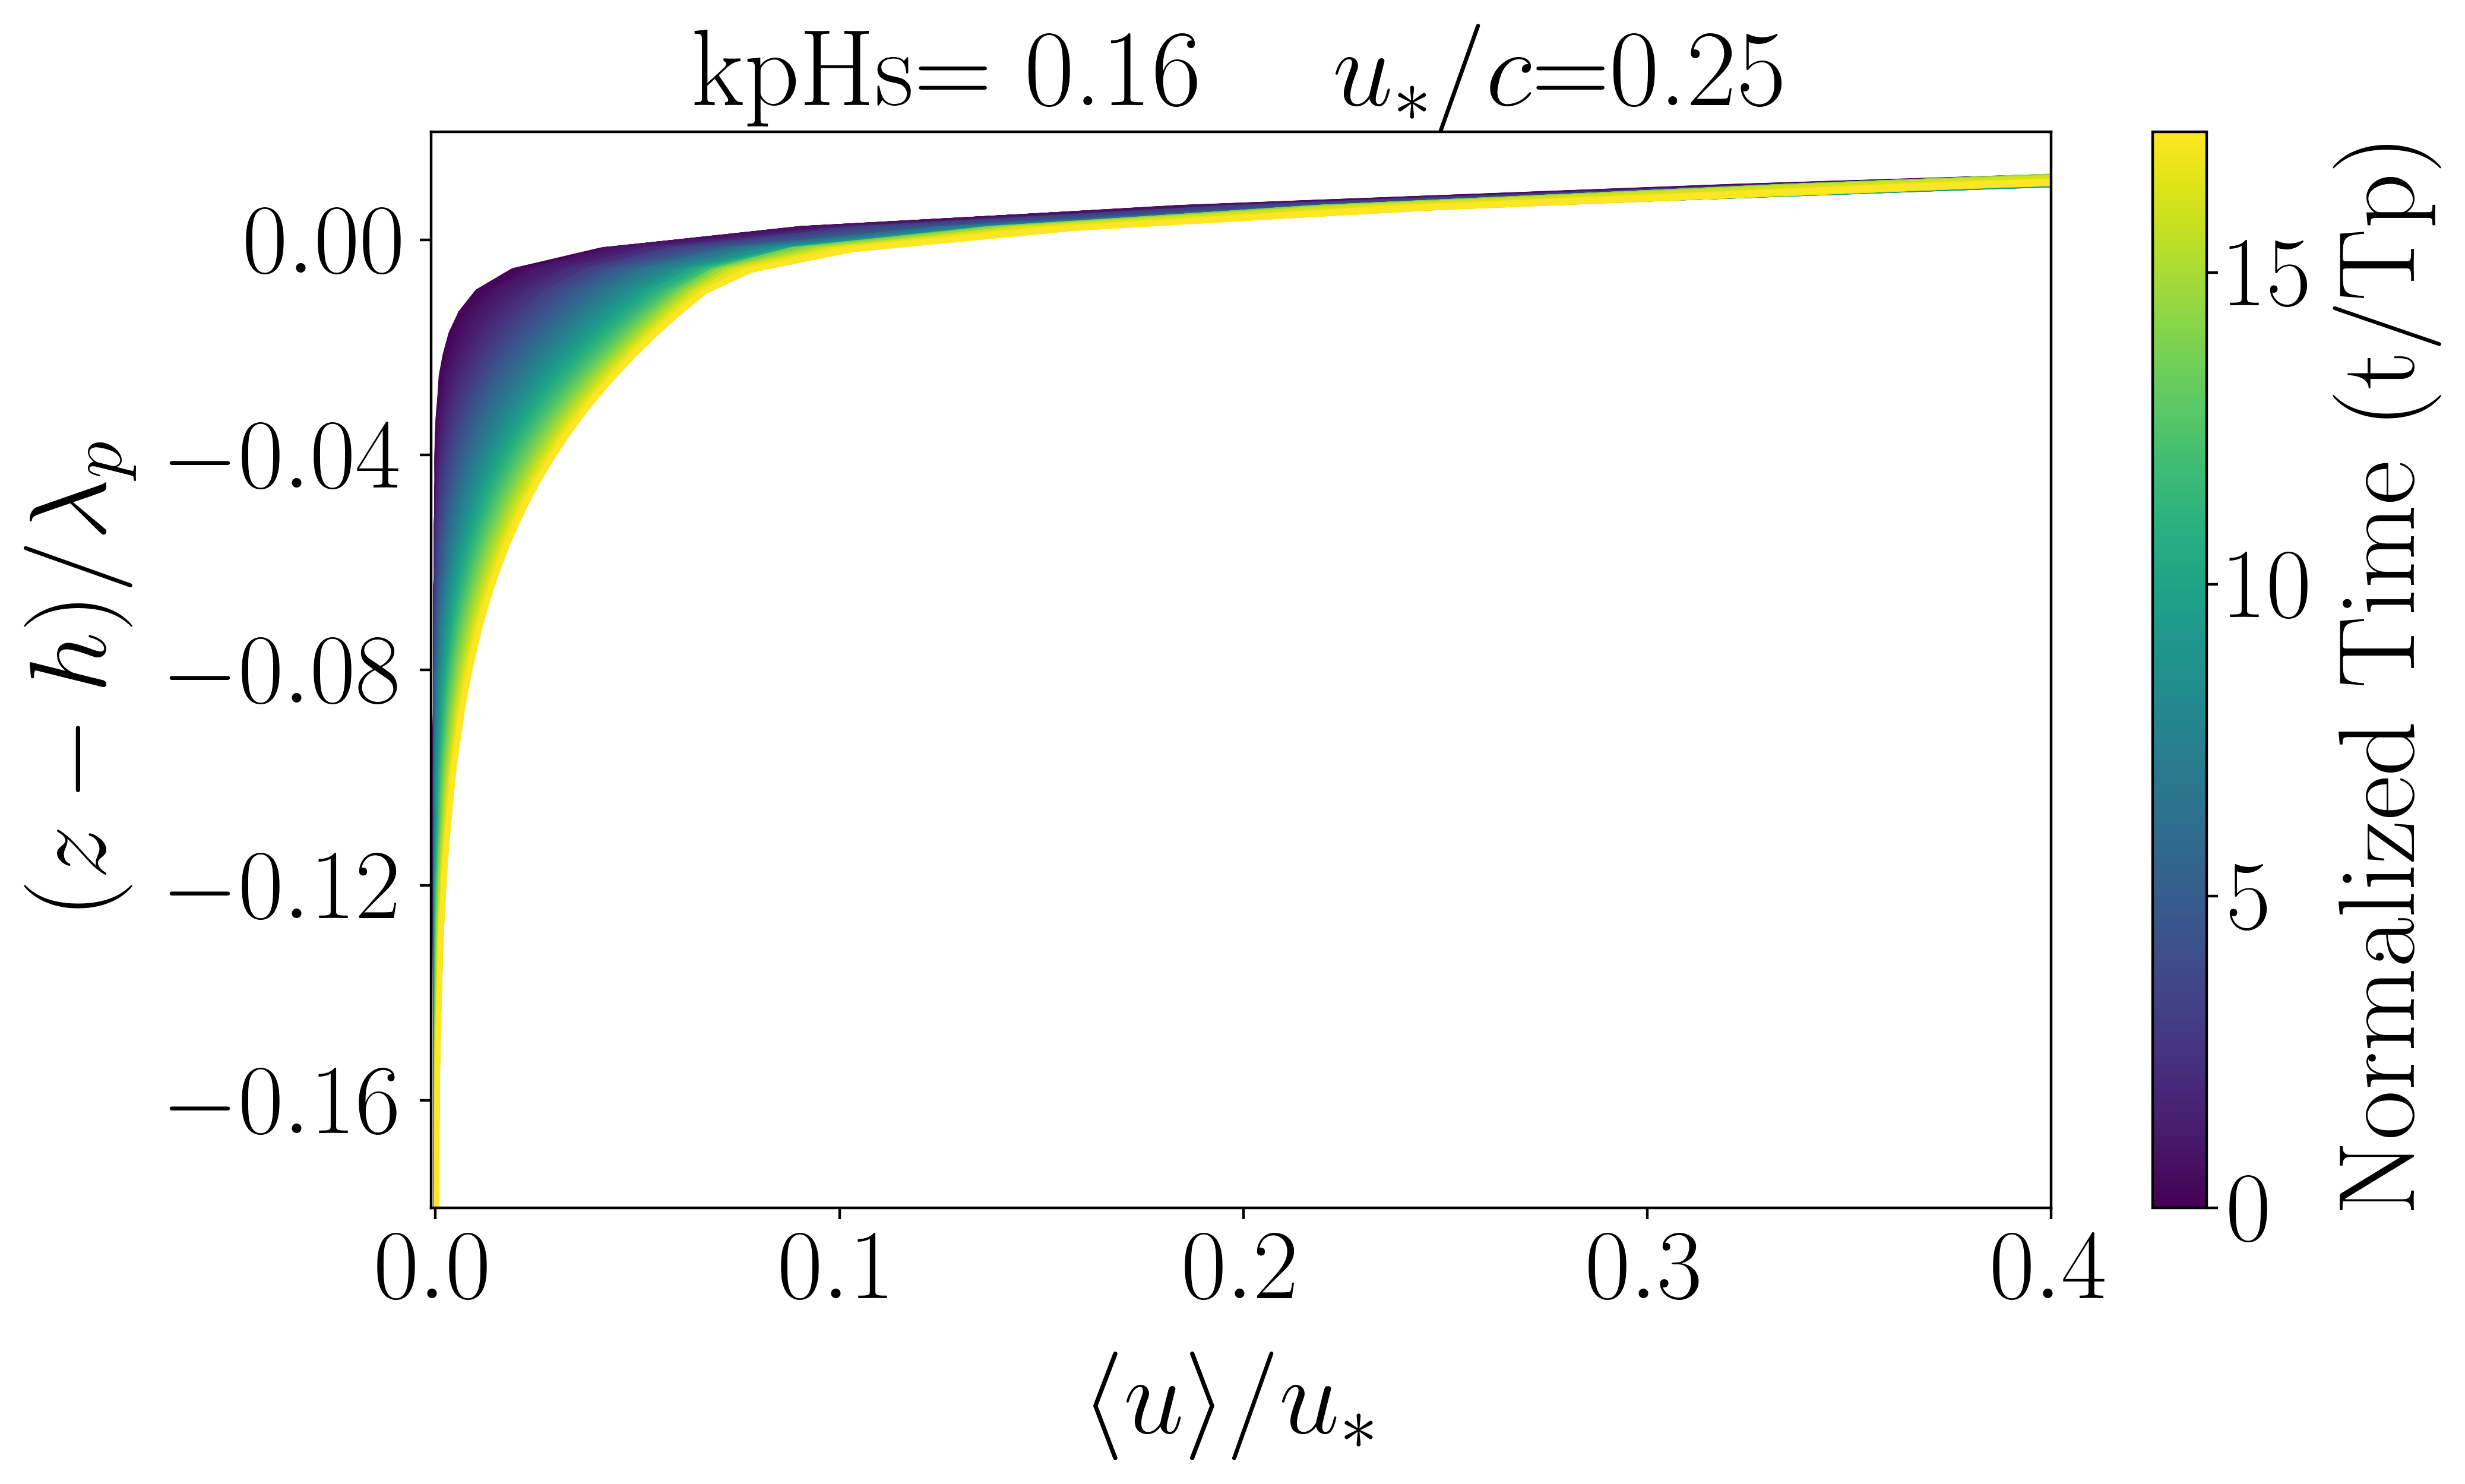

In [14]:
fig, ax = plt.subplots(figsize=[11, 6])

# Calcular los valores normalizados
time_normalized = (profiles_df['time'] - tstart_vel) * omegap / (2 * np.pi)
norm = Normalize(vmin=np.min(time_normalized), vmax=np.max(time_normalized))
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array(time_normalized) 

time = time_vel

for i in range(5,len(time_normalized)):
    #print('i', i)
    phi_str = profiles_df.at[i, 'phi']
    u_z_str = profiles_df.at[i, 'u.x']
    phi_array = np.array(ast.literal_eval(phi_str))
    u_z_array = np.array(ast.literal_eval(u_z_str))

    color = sm.to_rgba(time_normalized[i])
    norm = np.sqrt(8*nu_water*(time[i]-time[0]))
    norm2 = lambdap
    # Graficar con el color correspondiente
    ax.plot( u_z_array ,(phi_array-1)/norm2,  color=color) #/ (0.25**1) 


# Añade la barra de colores a la figura.
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Normalized Time (t/Tp)')
#plt.axhline(y = 0.64, color = 'grey', linestyle = '--',lw=0.8) 

# Establecer escala logarítmica para el eje x
#plt.yscale('log')
#plt.xlim([0.64,6]) #air
#plt.ylim([0.7,4])  #air
plt.xlim([-0.001,0.4]) #water
plt.ylim([-0.18,0.02]) #water
#plt.yscale('log')
# Configura las etiquetas y el título
plt.ylabel(r'$(z-h)/\lambda_{p}$', labelpad = 10)
plt.xlabel(r'$\langle u\rangle /u_\ast$', labelpad = 10)
title_str = f'kpHs= {ak} \quad  $ u_\\ast/c$={uoc_val}'
ax.set_title(title_str)
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))

# Mostrar la gráfica
plt.show()

### Velocity profile in each interval

In [15]:
tstart_vel = profiles_df['time'].iloc[0]
omegap = np.sqrt(1 * 4)

# Calcular los valores normalizados
time_normalized = (profiles_df['time'] - tstart_vel) * omegap / (2 * np.pi)

# Encontrar el índice del valor más cercano a 4.66
target = 4.66
idx_closest = np.argmin(np.abs(time_normalized - target))

# Definir la longitud del primer intervalo
interval_length = time_normalized.iloc[idx_closest]

# Crear una lista para almacenar los intervalos
intervals = []

# Inicializar el primer intervalo
start_idx = 0
end_idx = idx_closest
intervals.append((start_idx, end_idx))

# Crear los intervalos restantes con solapamiento de 0.5
overlap_fraction = 0.5
while end_idx < len(time_normalized) - 1:
    start_idx = int(end_idx - overlap_fraction * idx_closest)
    end_idx = start_idx + idx_closest
    if end_idx >= len(time_normalized):
        end_idx = len(time_normalized) - 1
    if time_normalized[end_idx] < (time_normalized[end_idx]-1):
        break
    intervals.append((start_idx, end_idx))

lambdap = 2 * np.pi / kp
norm2 = lambdap

# Crear subplots para cada intervalo
fig, axs = plt.subplots(nrows=len(intervals), figsize=(15, 8 * len(intervals)), sharex=True)

# Si solo hay un intervalo, axs no es una lista, así que lo convertimos en una lista
if len(intervals) == 1:
    axs = [axs]

# Colores para cada intervalo usando la paleta viridis
interval_colors = plt.cm.viridis(np.linspace(0, 1, len(intervals)))

# Crear un ScalarMappable para generar colores a partir de la paleta de colores
norm = Normalize(vmin=np.min(time_normalized), vmax=11.69)  # Ajustar el rango máximo a 11.69
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array(time_normalized)

# Graficar los perfiles de velocidad en cada intervalo
for j, (start, end) in enumerate(intervals):
    ax = axs[j]
    for i in range(start, end + 1):
        phi_str = profiles_df.at[i, 'phi']
        u_z_str = profiles_df.at[i, 'u.x']
        phi_array = np.array(ast.literal_eval(phi_str))
        u_z_array = np.array(ast.literal_eval(u_z_str))

        color = sm.to_rgba(time_normalized[i])
        ax.plot(u_z_array, (phi_array - 1) / norm2, color=color)

    interval_label = f"{time_normalized.iloc[start]:.2f} - {time_normalized.iloc[end]:.2f}"
    ax.set_xlim([-0.001, 0.1])  # water
    ax.set_ylim([-0.18, 0.01])  # water
    ax.set_ylabel(r'$(z-h)/\lambda_p$', labelpad=10)
    ax.set_xlabel(r'$\langle u\rangle /u_\ast$', labelpad=10)  # /u_ast
    ax.set_title(f'Interval: [{interval_label}] $(t/Tp)$', pad=20)  # Aumenta el valor de pad para evitar la superposición

# Añadir la barra de colores a la figura.
#cbar = fig.colorbar(sm, ax=axs, orientation='horizontal', fraction=0.02, pad=0.04)
#cbar.set_label('Normalized Time (t/Tp)')

plt.tight_layout()
plt.show()


0.07954134043338498
[array(0.07954134)]
0.09349342284774403
[array(0.07954134), array(0.09349342)]
0.10408703502495317
[array(0.07954134), array(0.09349342), array(0.10408704)]
0.11065251830386005
[array(0.07954134), array(0.09349342), array(0.10408704), array(0.11065252)]
0.11400130592647166
[array(0.07954134), array(0.09349342), array(0.10408704), array(0.11065252), array(0.11400131)]
0.11678249876443646
[array(0.07954134), array(0.09349342), array(0.10408704), array(0.11065252), array(0.11400131), array(0.1167825)]
0.12070361922925614
[array(0.07954134), array(0.09349342), array(0.10408704), array(0.11065252), array(0.11400131), array(0.1167825), array(0.12070362)]


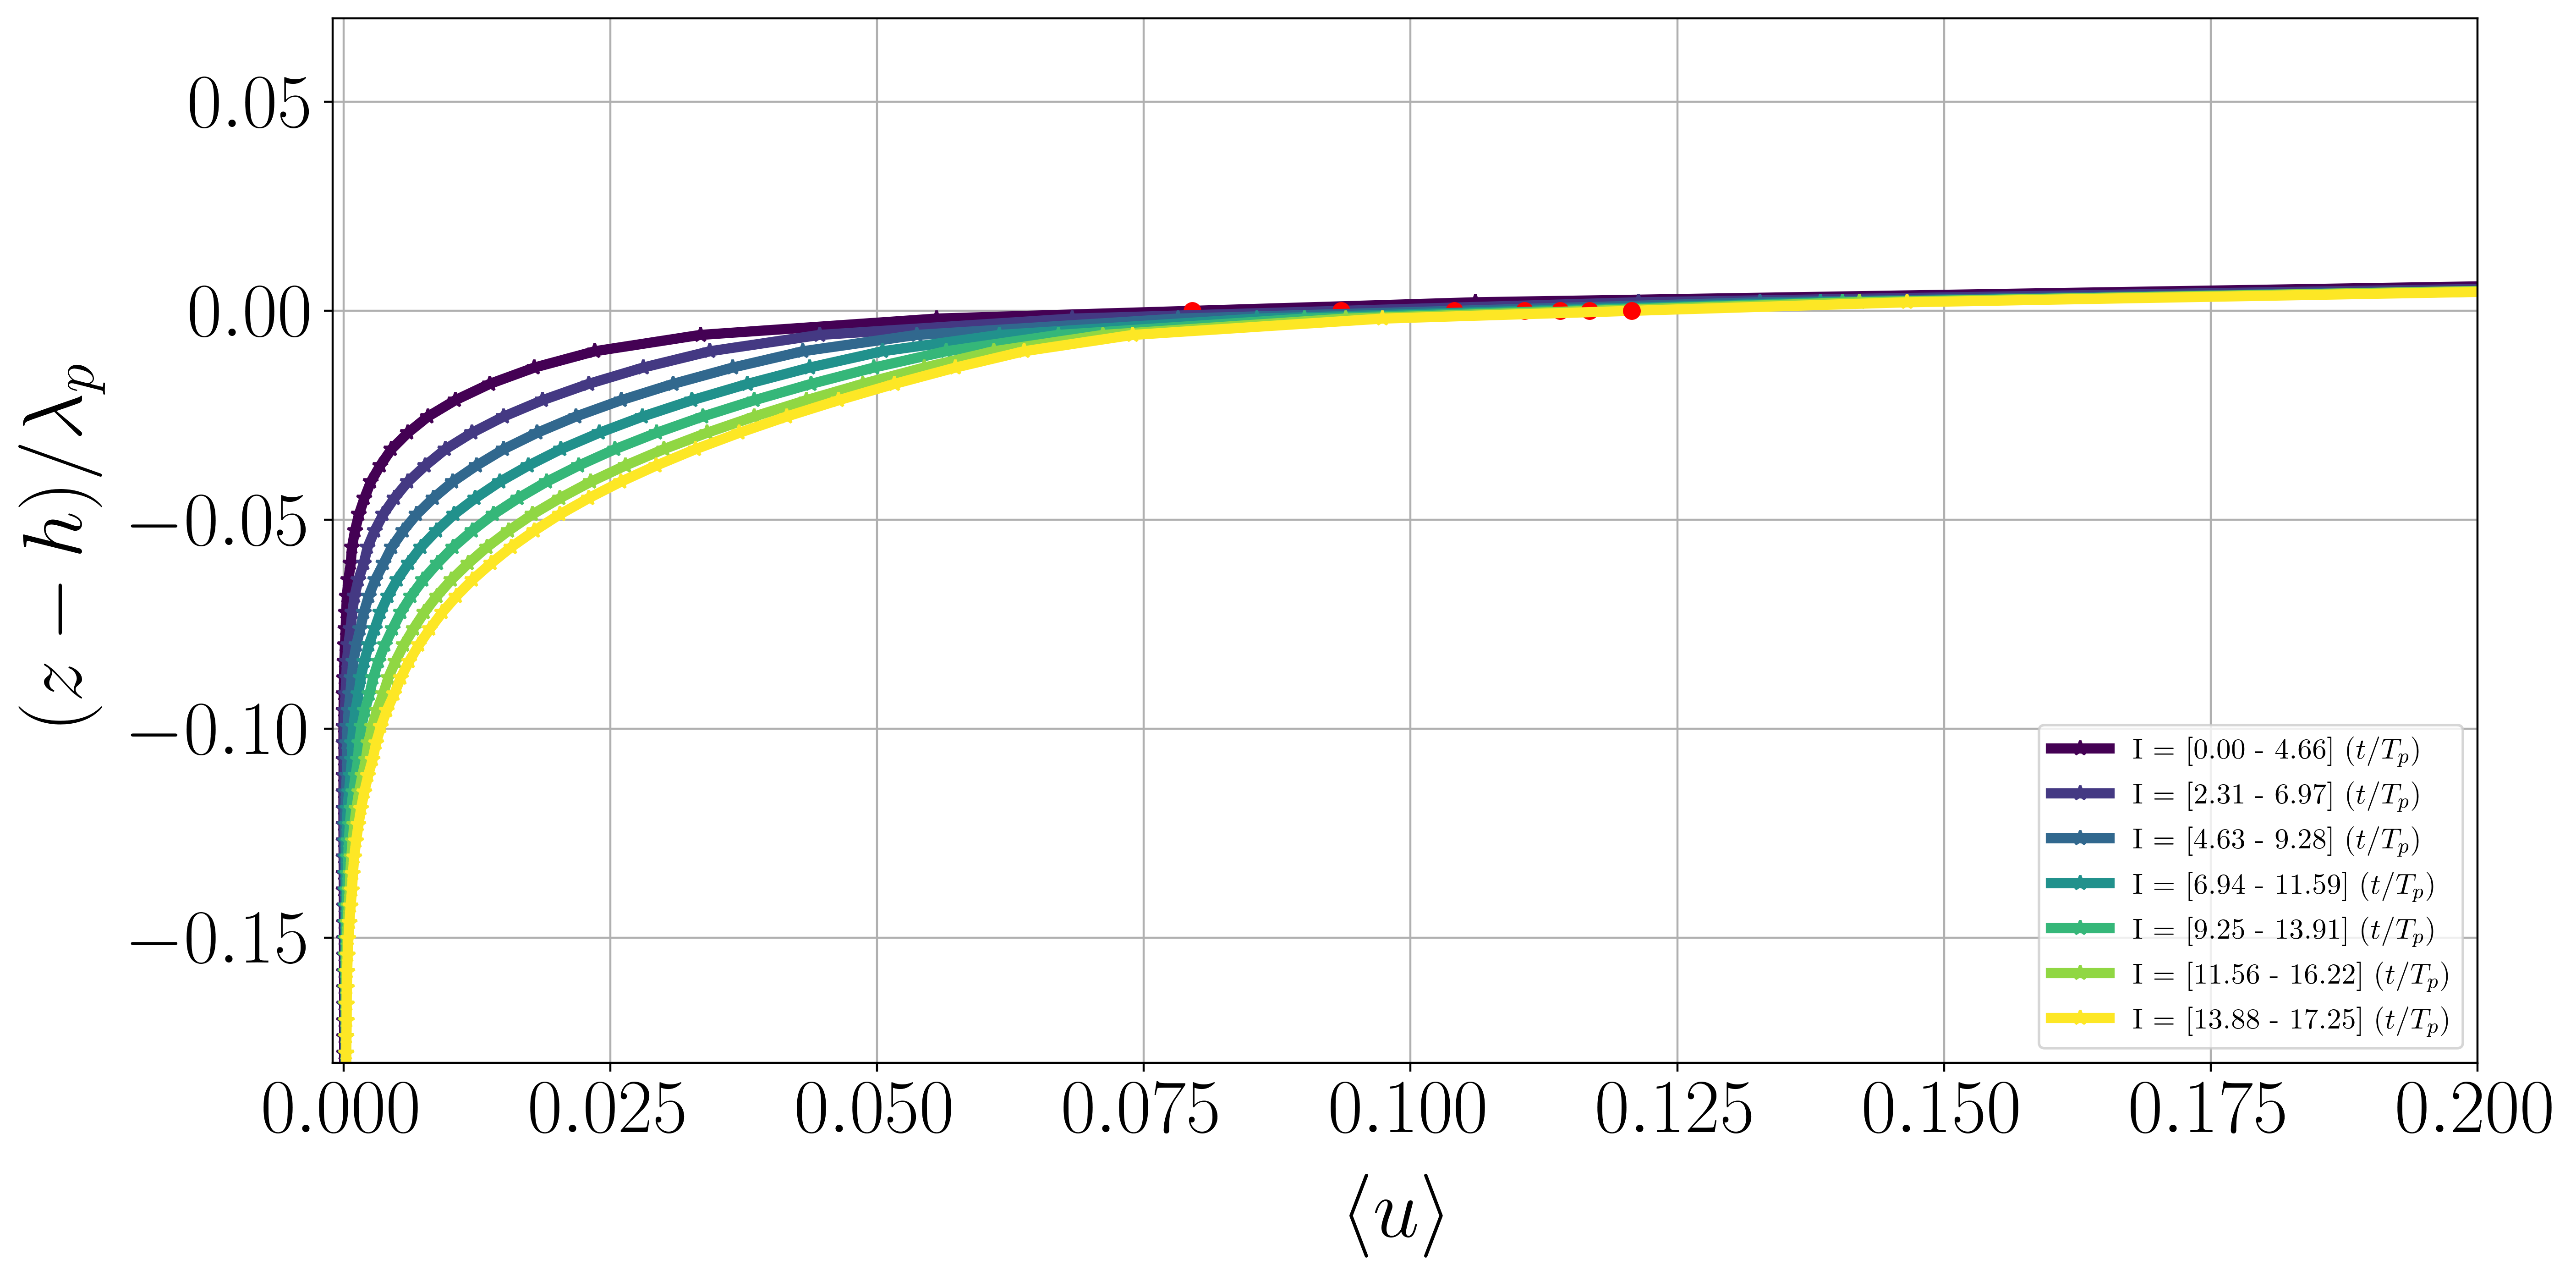

In [16]:
from scipy.interpolate import interp1d

target = 4.66 #2T0
idx_closest = np.argmin(np.abs(time_normalized - target))

# Definir la longitud del primer intervalo
interval_length = time_normalized.iloc[idx_closest]

# Crear una lista para almacenar los intervalos
intervals = []

# Inicializar el primer intervalo
start_idx = 0
end_idx = idx_closest
intervals.append((start_idx, end_idx))

# Crear los intervalos restantes con solapamiento de 0.5 y detenerse en 11.69
overlap_fraction = 0.5
while end_idx < len(time_normalized) - 1:
    start_idx = int(end_idx - overlap_fraction * idx_closest)
    end_idx = start_idx + idx_closest
    if end_idx >= len(time_normalized):
        end_idx = len(time_normalized) - 1
    if time_normalized[end_idx] < (time_normalized[end_idx]-1):
        break
    intervals.append((start_idx, end_idx))

phi_avg = []
u_x_avg = []

for start, end in intervals:
    accumulated_u_x = None
    count = 0

    for i in range(start, end + 1):
        phi_str = profiles_df.at[i, 'phi']
        u_x_str = profiles_df.at[i, 'u.x']
        phi_array = np.array(ast.literal_eval(phi_str))
        u_x_array = np.array(ast.literal_eval(u_x_str))

        if accumulated_u_x is None:
            accumulated_u_x = np.zeros_like(u_x_array)

        accumulated_u_x += u_x_array
        count += 1

    if count > 0:
        average_u_x = accumulated_u_x / count
    else:
        average_u_x = np.zeros_like(accumulated_u_x)

    phi_avg.append(phi_array)
    u_x_avg.append(average_u_x)

lambdap = 2 * np.pi / kp
norm2 = lambdap

interval_colors = plt.cm.viridis(np.linspace(0, 1, len(intervals)))

u_atzero=[]
plt.figure(figsize=(14, 7))
for i, (phi, u_x) in enumerate(zip(phi_avg, u_x_avg)):
    interval_label = f"{time_normalized.iloc[intervals[i][0]]:.2f} - {time_normalized.iloc[intervals[i][1]]:.2f}"
    phi_normalized = (phi - 1) / norm2
    plt.plot(u_x, phi_normalized, lw=4, label=f"I = [{interval_label}]  $(t/T_{{p}})$", color=interval_colors[i], marker='*')

    # Interpolación para encontrar u_x en z = 0
    if np.min(phi_normalized) <= 0 <= np.max(phi_normalized):  # Asegurarse de que 0 esté en el rango de phi_normalized
        interp_func = interp1d(phi_normalized, u_x, kind='linear', fill_value="extrapolate")
        u_at_z0 = interp_func(0)
        print(u_at_z0)
        u_atzero.append(u_at_z0)
        print(u_atzero)
        plt.plot(u_at_z0, 0, 'ro')  # Marcar los puntos interpolados en el gráfico
    
    
# Establecer los límites de los ejes
plt.xlim([-0.001, 0.2])  # water
plt.ylim([-0.18, 0.07])  # water

plt.ylabel(r'$(z-h)/\lambda_{p}$', labelpad=10)
plt.xlabel(r'$\langle u\rangle$', labelpad=10)  #  /u_\ast
#plt.title(r'$kpHs= 0.08 \quad  \quad u_\ast/c=0.5$')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [17]:
# Create a dictionary with the lists
data = {
    'phi_avg': phi_avg,
    'ux_avg': u_x_avg
}

# Create a DataFrame from the dictionary
df_meanvelocity = pd.DataFrame(data)
# Guarda el DataFrame recortado si es necesario
df_meanvelocity.to_csv(f'/projects/DEIKE/cmartinb/mean_velocity/mean_velocity_kpHs{kpHs}_uoc{uoc}.csv', index=False)
# Display the DataFrame
print(df_meanvelocity)

                                             phi_avg  \
0  [0.003067962, 0.009203885, 0.01533981, 0.02147...   
1  [0.003067962, 0.009203885, 0.01533981, 0.02147...   
2  [0.003067962, 0.009203885, 0.01533981, 0.02147...   
3  [0.003067962, 0.009203885, 0.01533981, 0.02147...   
4  [0.003067962, 0.009203885, 0.01533981, 0.02147...   
5  [0.003067962, 0.009203885, 0.01533981, 0.02147...   
6  [0.003067962, 0.009203885, 0.01533981, 0.02147...   

                                              ux_avg  
0  [1.2134113337333335e-07, 1.2134113337333335e-0...  
1  [2.57872704e-07, 2.57872704e-07, 2.57872704e-0...  
2  [4.681064014666666e-07, 4.681064014666666e-07,...  
3  [7.006870920000002e-07, 7.006870920000002e-07,...  
4  [9.249372900000002e-07, 9.249372900000002e-07,...  
5  [1.1337310120000003e-06, 1.1337310120000003e-0...  
6  [1.2841343394495412e-06, 1.2841343394495412e-0...  


2.328125001069888
3.4843749992513096
4.64062499743273
5.7968750115296945
6.9531250097111155
8.109375007892536
8.62500000407057


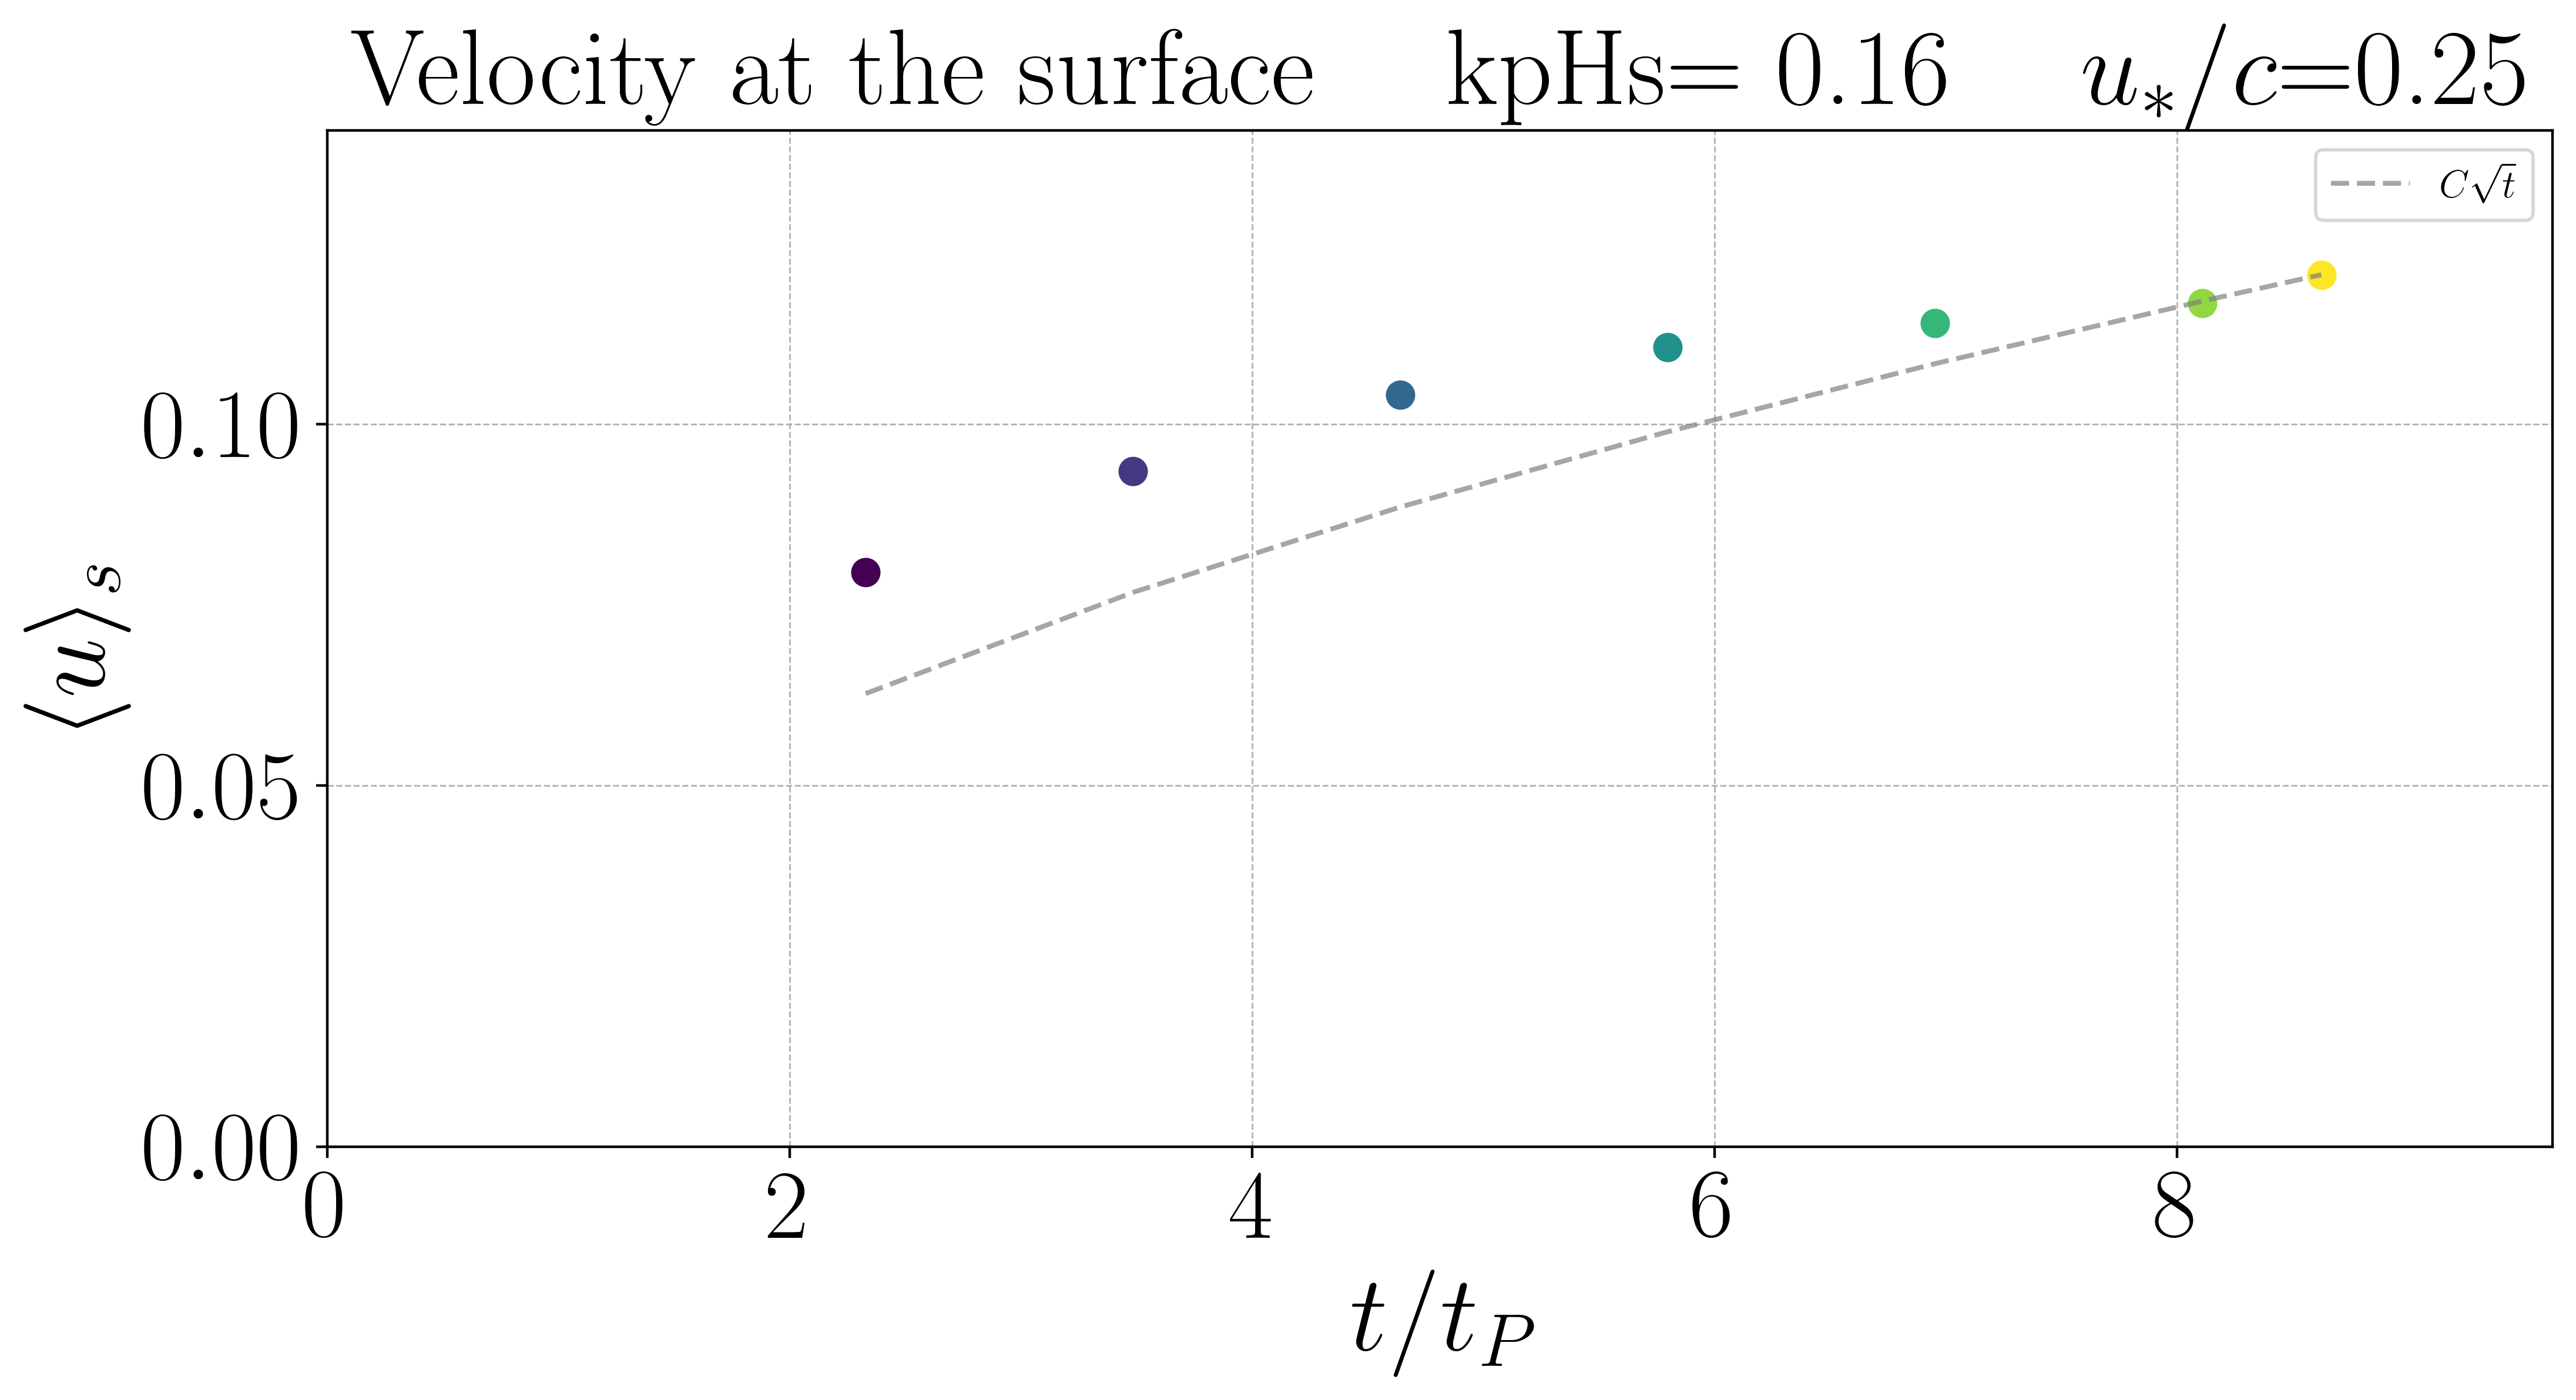

In [18]:
# Data for the second plot
times_moyen_08 = np.array([4.69/2, (2.31+7)/2, (4.62 + 9.31)/2, (6.94 + 11.63)/2, (9.37+14.03)/2, (11.72+16.37)/2, (14.06+18.72)/2])

# Create the figure and axis
fig, ax = plt.subplots(figsize=(11, 6))

times_moyens =[]
# Plot the data
for i, color in enumerate(interval_colors):
    time_moyen = time_normalized[intervals[i][1]]/2
    print(time_normalized[intervals[i][1]]/2)
    ax.plot(time_moyen, u_atzero[i], marker='o', linestyle='-', color=color, markersize=8, linewidth=2)
    times_moyens.append(time_moyen)
    
    
# Normalize the sqrt function to better match the data range
sqrt_times_moyen = np.sqrt(np.array(times_moyens))
max_u_atzero = max(u_atzero)
normalized_sqrt_times = sqrt_times_moyen * (max_u_atzero / max(sqrt_times_moyen))
ax.plot(times_moyens, normalized_sqrt_times, ls='--', color='grey', alpha=0.7, label=r'$C \sqrt{t}$')

# Add title and labels
title_str = f'Velocity at the surface \quad kpHs= {ak} \quad  $ u_\\ast/c$={uoc_val}'
ax.set_title(title_str)
ax.set_xlabel(f'$t/t_{{P}}$')
ax.set_ylabel(r'$\langle u \rangle_{s}$')

# Add a grid
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Add a legend
ax.legend(fontsize=12)

# Set axis limits
ax.set_xlim([0, max(times_moyens) + 1])
ax.set_ylim([0, max(u_atzero) + 0.02])

# Show the plot
plt.tight_layout()
plt.show()

# Mean velocity profile

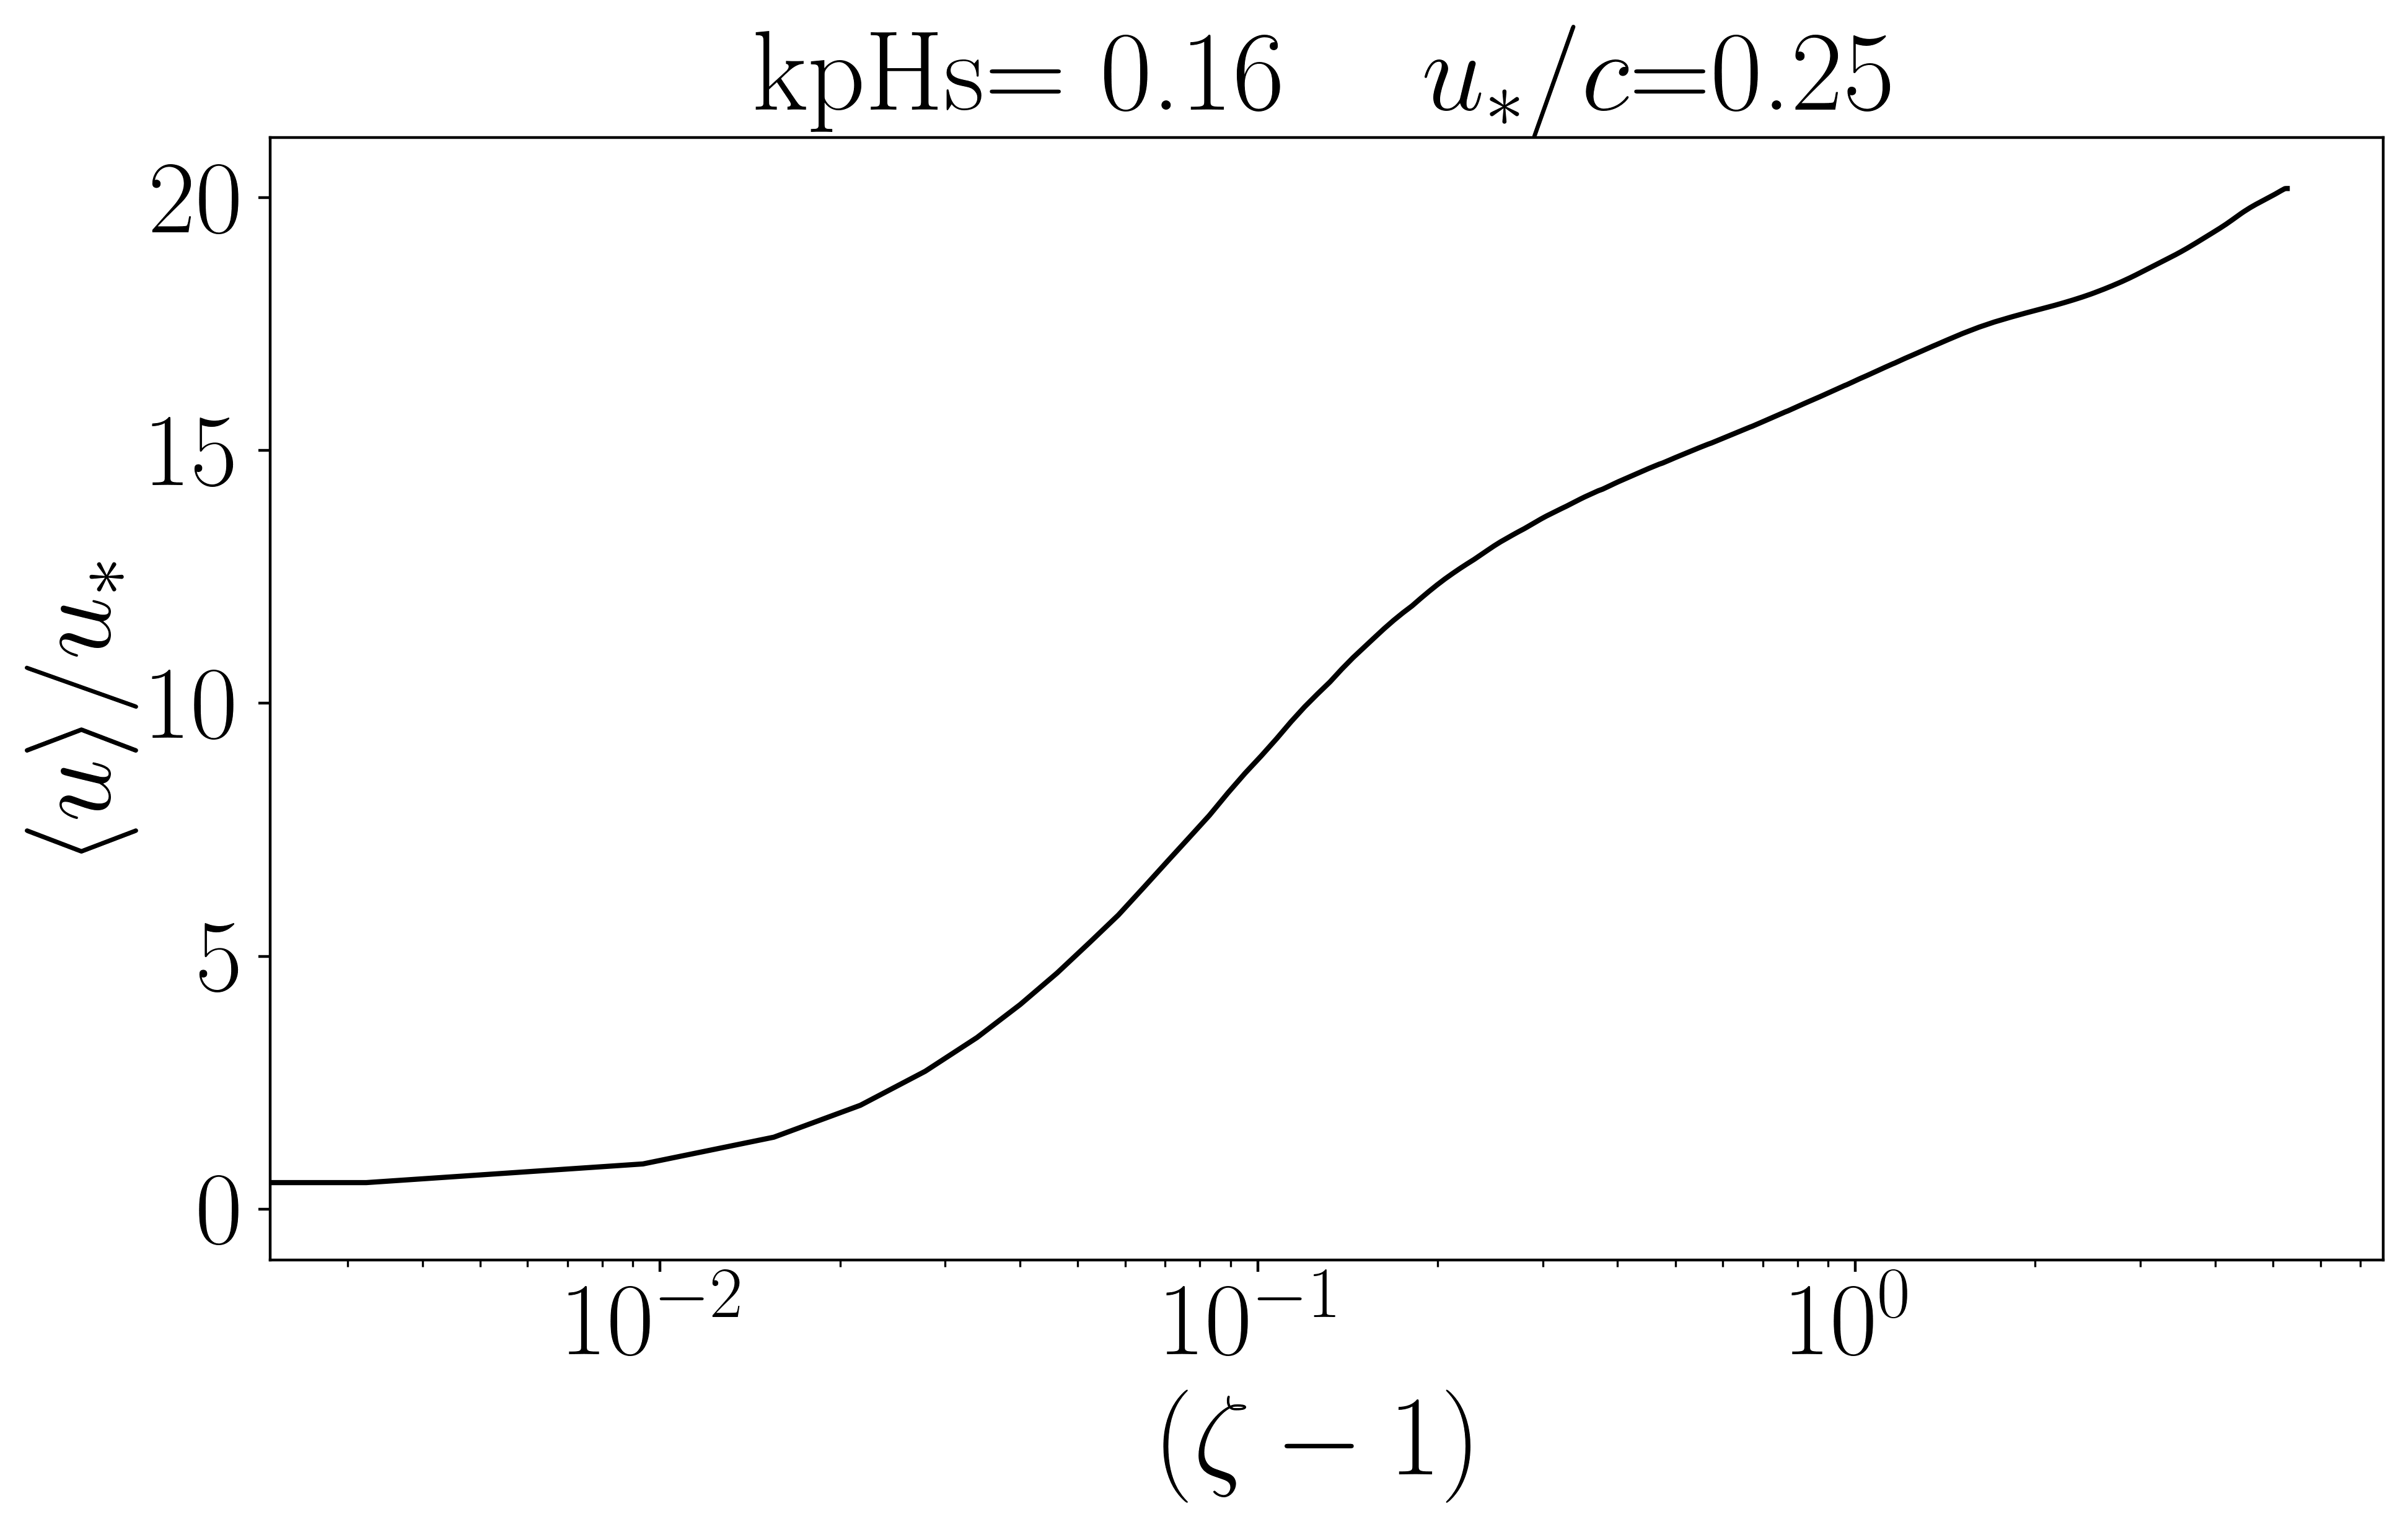

In [19]:
fig, ax = plt.subplots(figsize=[11, 6])
norm = Normalize(vmin=0, vmax=299)
sm = plt.cm.ScalarMappable(cmap=viridis, norm=norm)
sm.set_array([])

accumulated_u_z = np.zeros_like(np.array(ast.literal_eval(profiles_df.at[0, 'u.x'])))

for i in range(len(profiles_df)):
    u_z_str = profiles_df.at[i, 'u.x']
    u_z_array = np.array(ast.literal_eval(u_z_str))
    accumulated_u_z += u_z_array

average_u_z = accumulated_u_z / len(profiles_df)

ax.plot(phi_array-1, average_u_z/(0.25**1), color='black')  # color='black' para la línea promedio

plt.xscale('log')
plt.xlabel(r'$(\zeta - 1) $')
plt.ylabel(r'$\langle u\rangle /u_\ast$')
title_str = f'kpHs= {ak} \quad  $ u_\\ast/c$={uoc_val}'
ax.set_title(title_str)

#fig.save(fig_dir+"/
plt.show()

# Velocity fluctuations

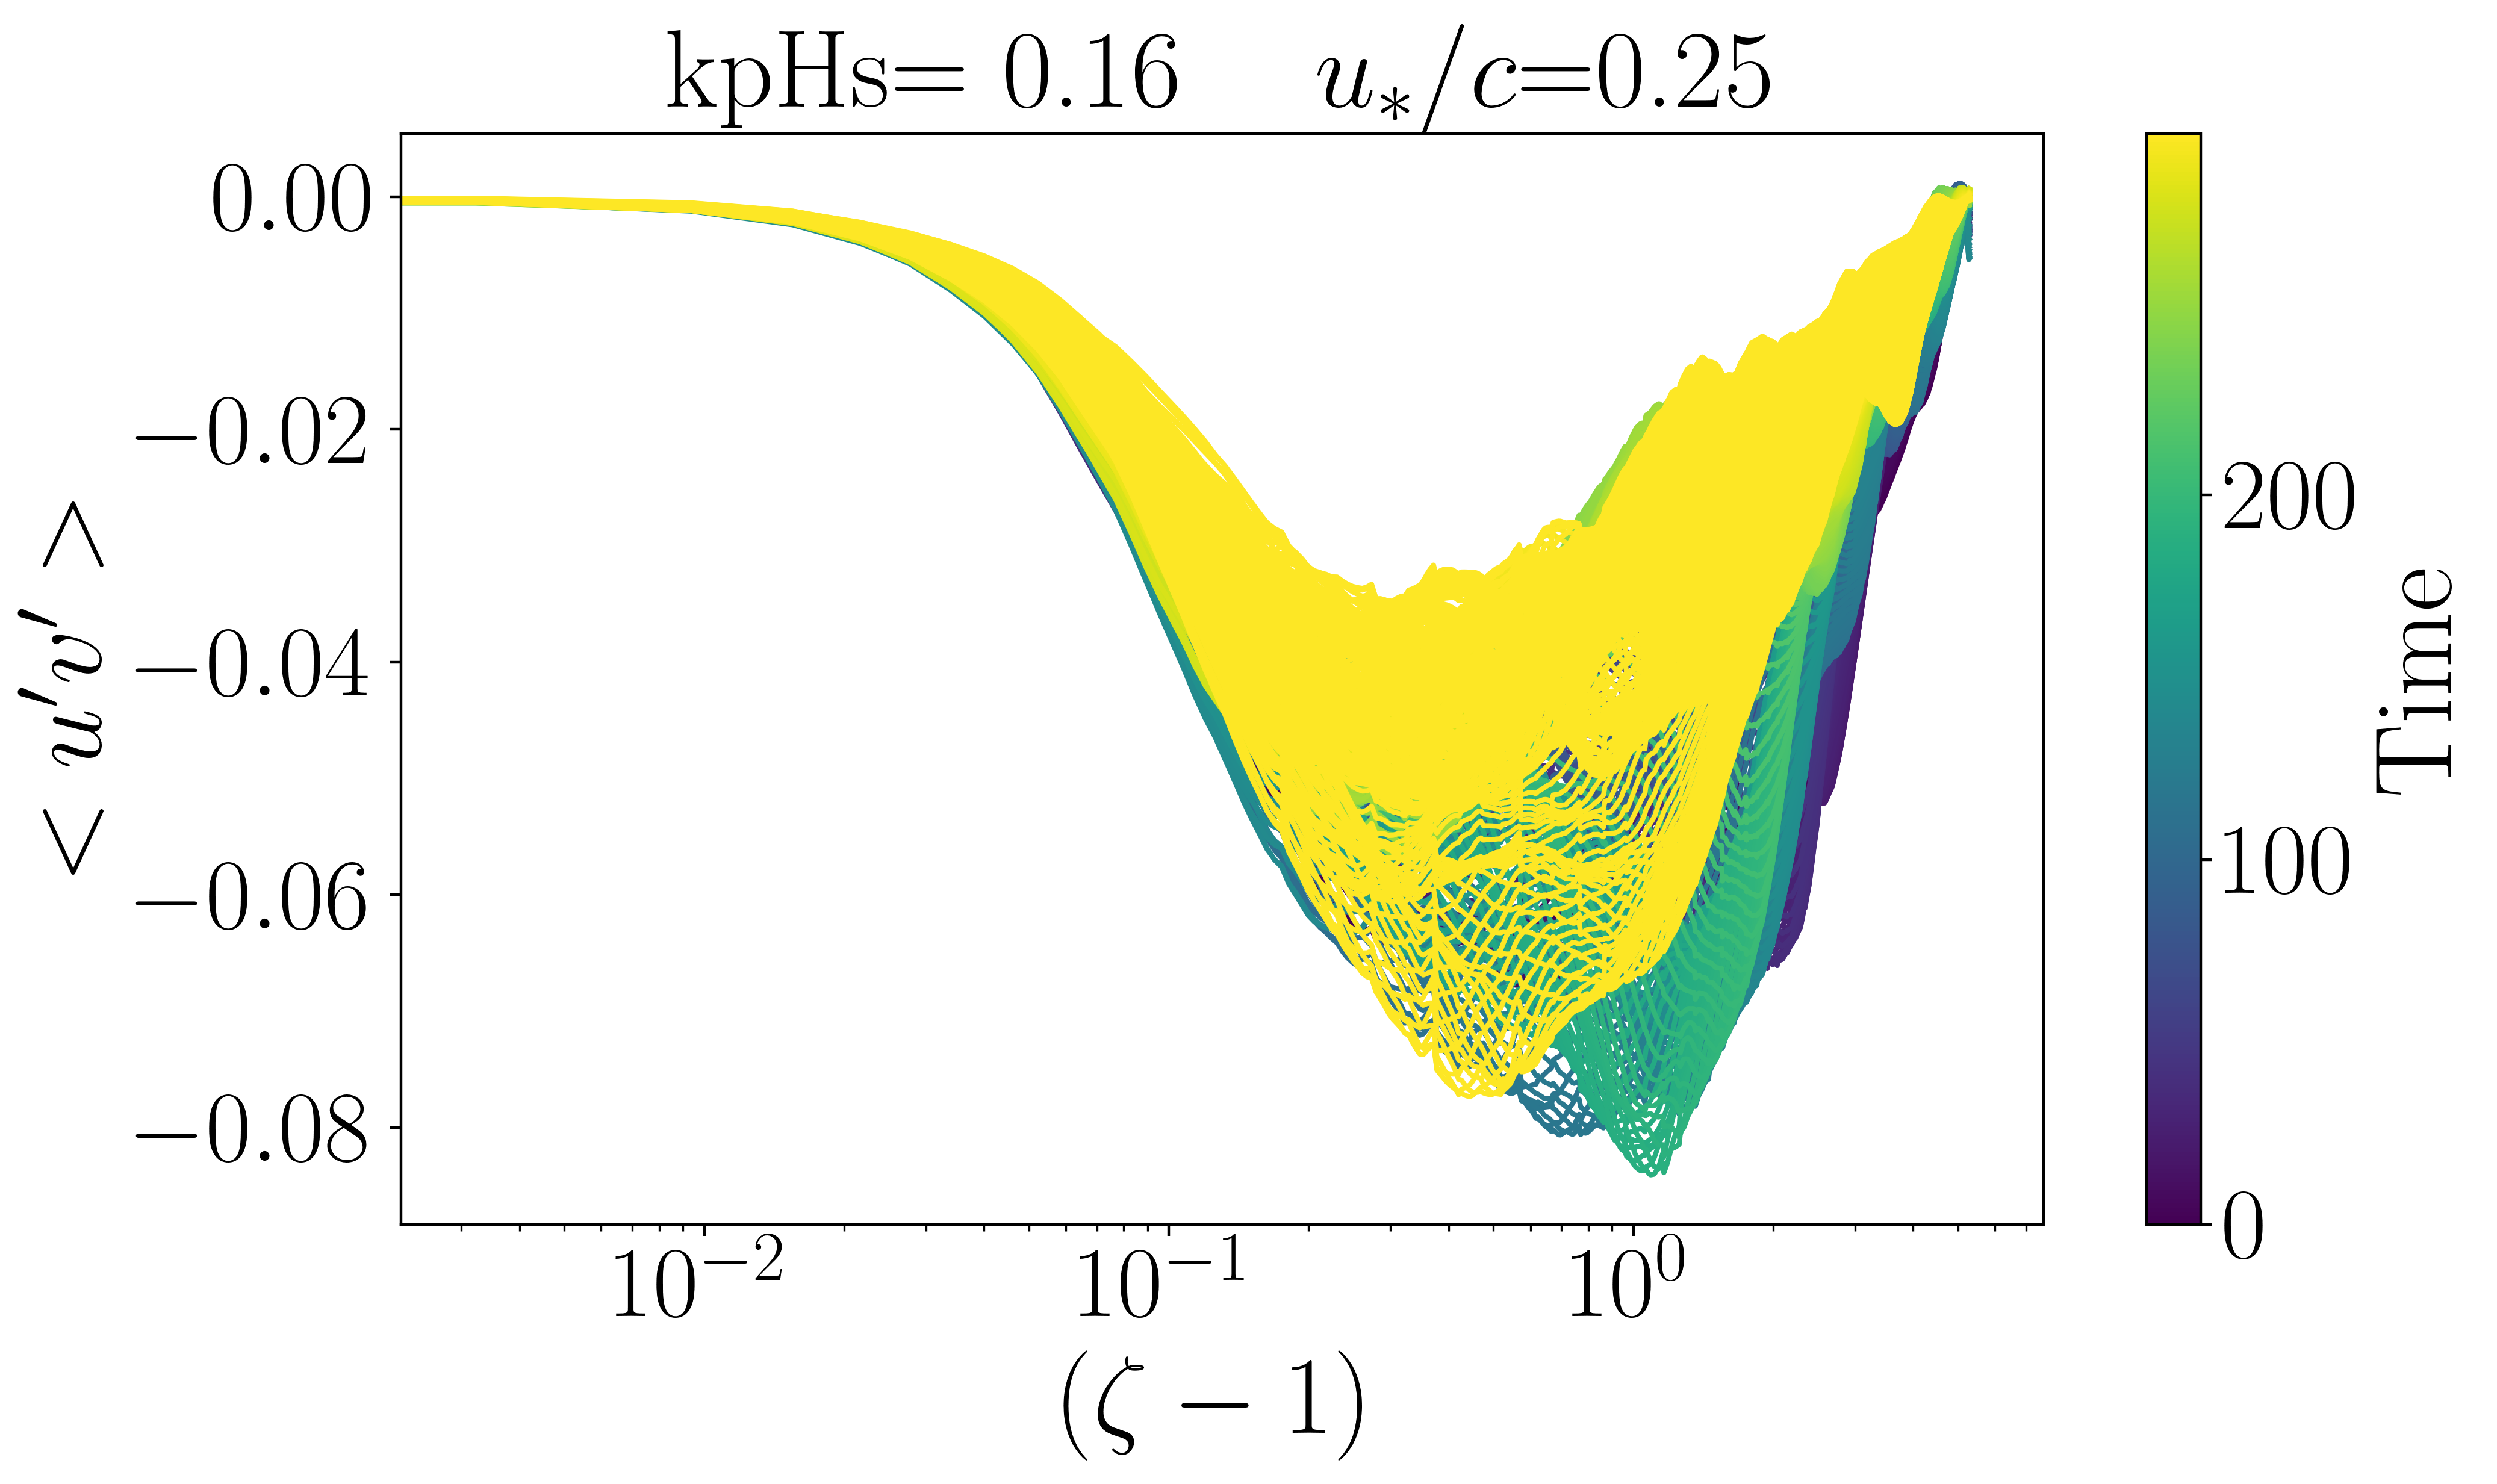

In [20]:
fig, ax = plt.subplots(figsize=[11, 6])

norm = Normalize(vmin=0, vmax=299)


sm = plt.cm.ScalarMappable(cmap=viridis, norm=norm)
sm.set_array([]) 

# 'phi', 'uv', 'u.x' y 'u.z' 
for i in range(len(profiles_df)):
    phi_array = np.array(ast.literal_eval(profiles_df.at[i, 'phi']))
    uv_array = np.array(ast.literal_eval(profiles_df.at[i, 'uv']))
    u_x_array = np.array(ast.literal_eval(profiles_df.at[i, 'u.x']))
    u_z_array = np.array(ast.literal_eval(profiles_df.at[i, 'u.y']))

    # Calcul fluctuations
    fluctuations_array = uv_array - u_x_array * u_z_array
    calc_array = (phi_array - 1) * 720
    # Color as time
    color = sm.to_rgba(i)
    ax.plot((phi_array - 1) , fluctuations_array, color=color)

cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Time')
ax.set_xscale('log')  
ax.set_xlabel(r'$(\zeta - 1)$')
ax.set_ylabel(r'$<u^\prime v^\prime>$')
title_str = f'kpHs= {ak} \quad  $ u_\\ast/c$={uoc_val}'
ax.set_title(title_str)
plt.show()

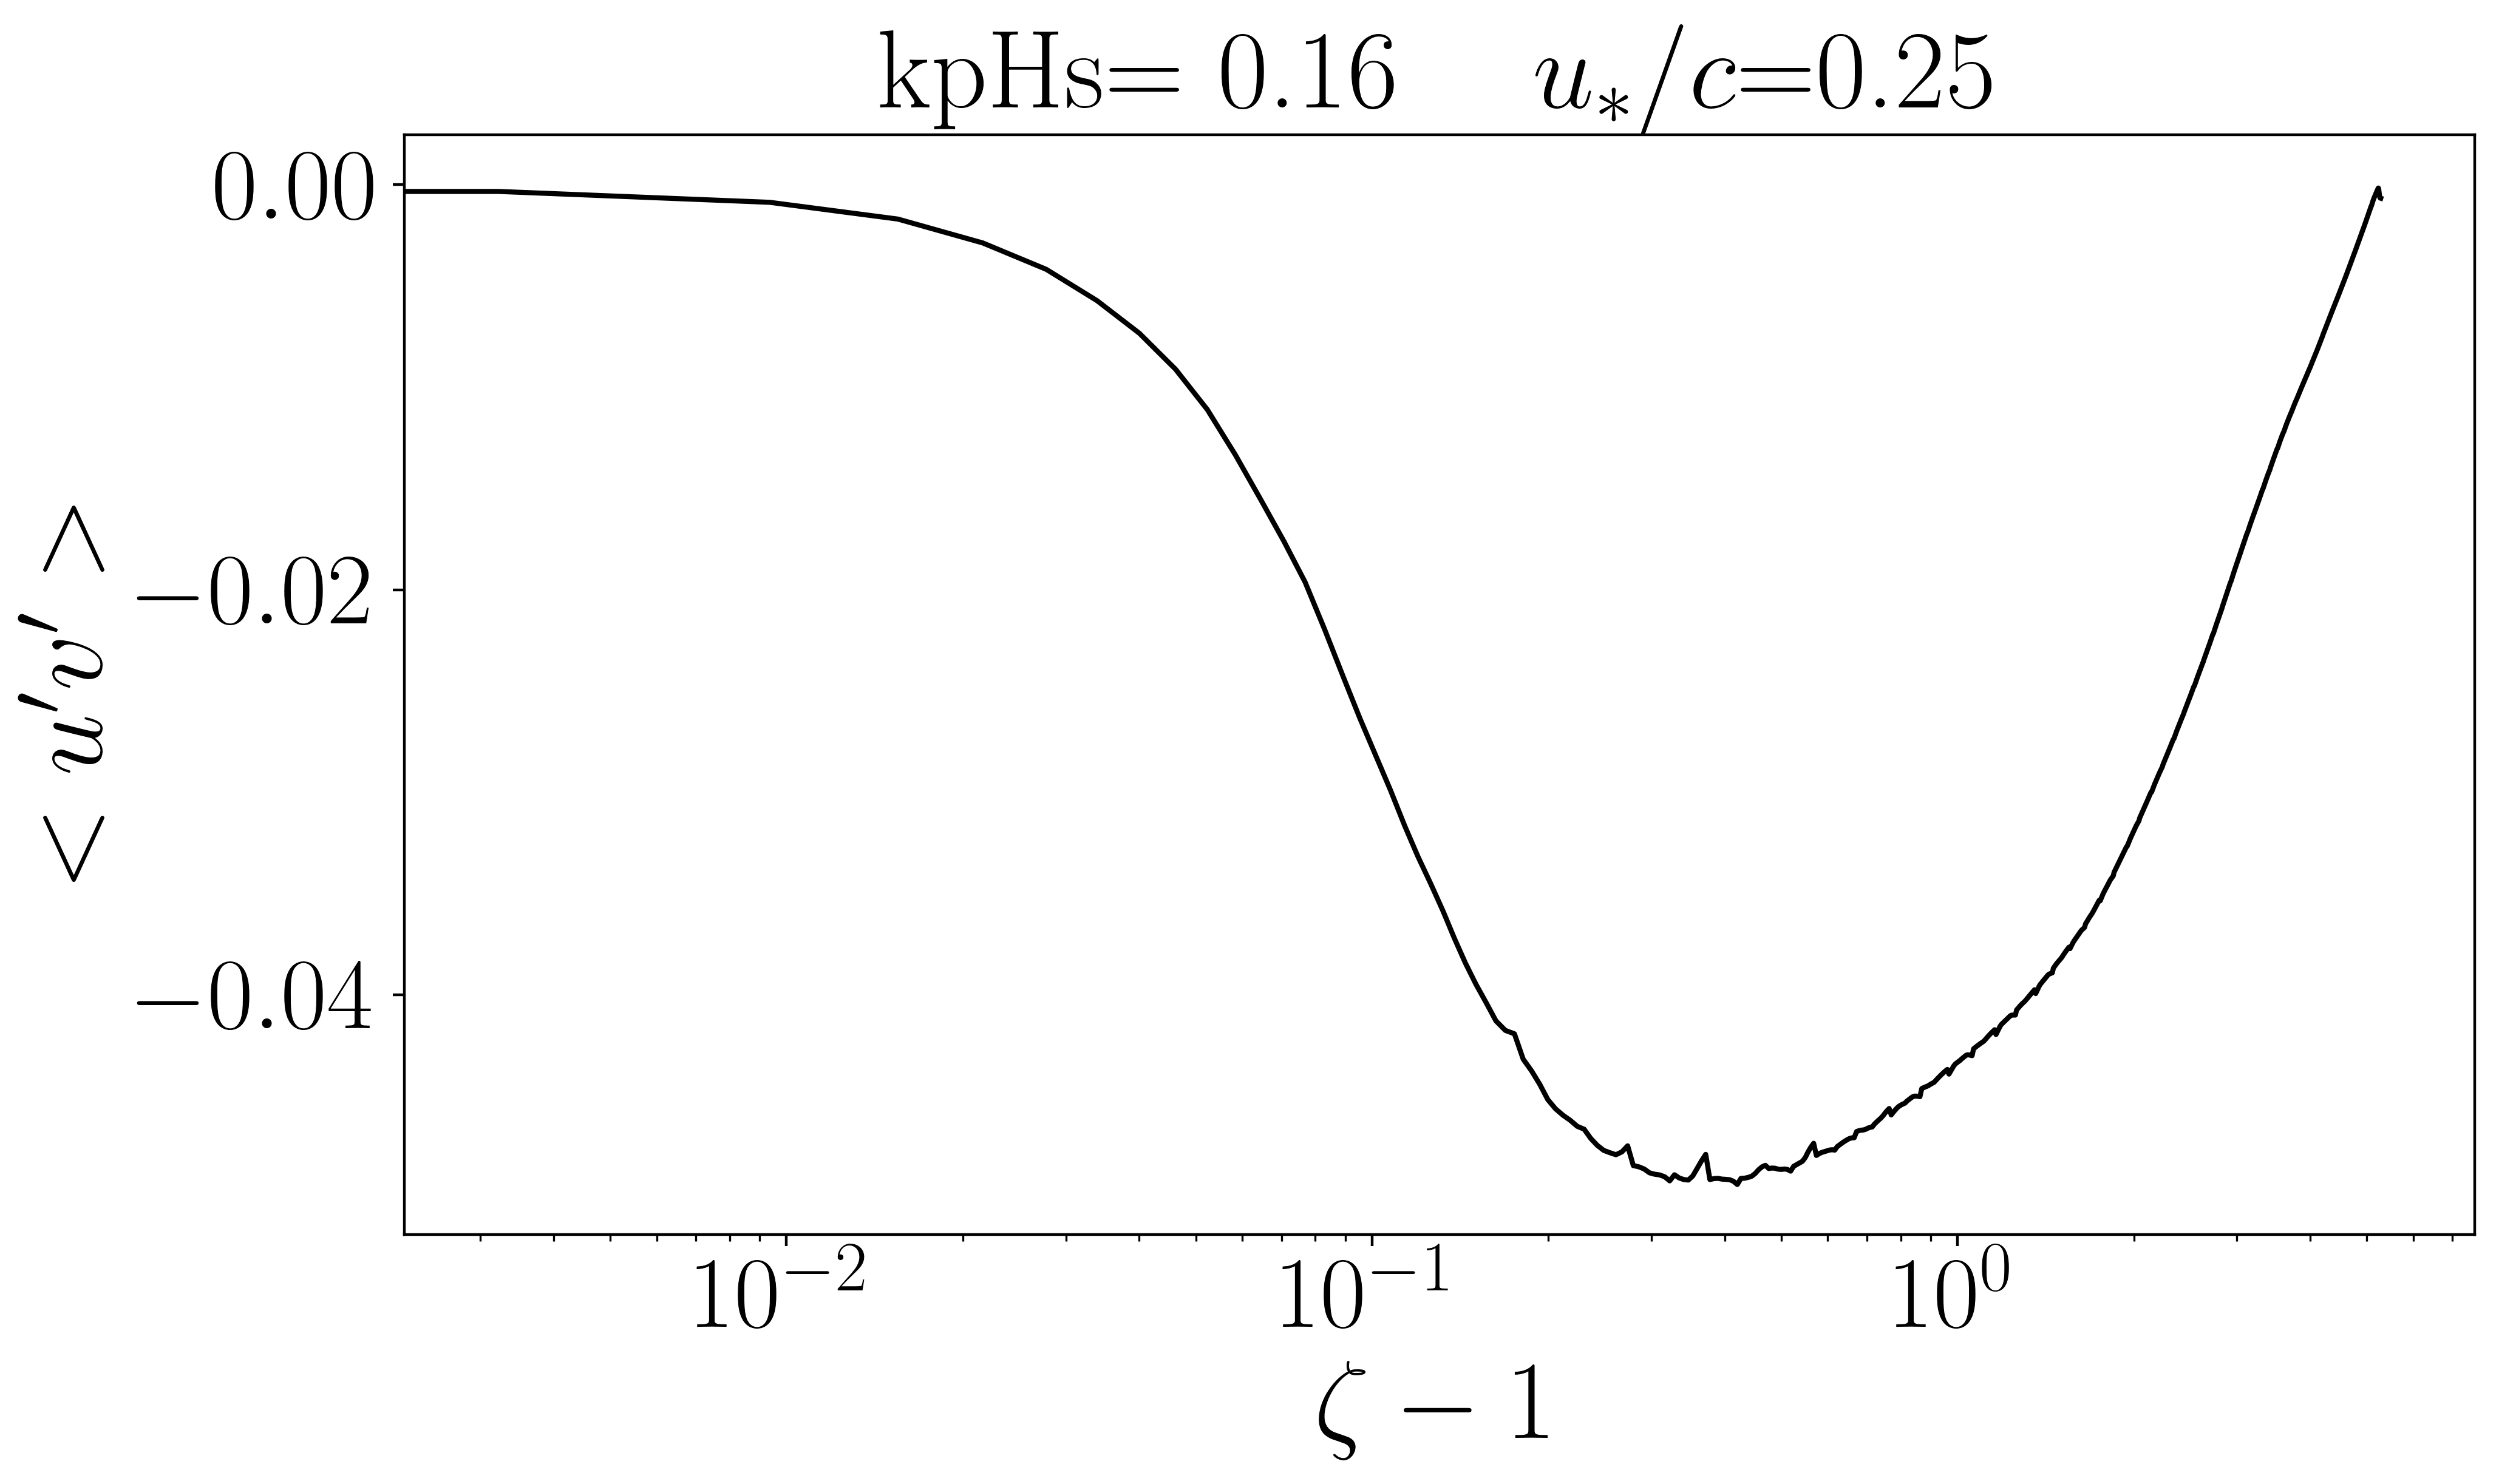

In [21]:
#MEAN FLUCTUATIONS

# Preparar la figura y los ejes
fig, ax = plt.subplots(figsize=[11, 6])

# Inicializar un arreglo para acumular las fluctuaciones
accumulated_fluctuations = None

# Calcular y acumular las fluctuaciones para cada tiempo
for i in range(len(profiles_df)):
    # Convertir de string a array numérico real
    phi_array = np.array(ast.literal_eval(profiles_df.at[i, 'phi']))
    uv_array = np.array(ast.literal_eval(profiles_df.at[i, 'uv']))
    u_x_array = np.array(ast.literal_eval(profiles_df.at[i, 'u.x']))
    u_z_array = np.array(ast.literal_eval(profiles_df.at[i, 'u.y']))

    # Calcular fluctuaciones
    fluctuations_array = uv_array - u_x_array * u_z_array
    if accumulated_fluctuations is None:
        accumulated_fluctuations = np.zeros_like(fluctuations_array)
    accumulated_fluctuations += fluctuations_array

# Calcular el promedio de las fluctuaciones
average_fluctuations = accumulated_fluctuations / len(profiles_df)

# Calcular calc_array usando el primer 'phi_array' como representante, asumiendo que es constante
calc_array = (np.array(ast.literal_eval(profiles_df.at[0, 'phi'])) - 1) * 720

# Graficar el promedio de las fluctuaciones
ax.plot(phi_array-1, average_fluctuations, color='black', label='Average Fluctuations')

# Añadir la barra de colores

ax.set_xscale('log')
# Etiquetas y título
#ax.set_xlabel(r'$(\zeta - 1) 720$')
ax.set_xlabel(r'$\zeta -1 $')
ax.set_ylabel(r'$<u^\prime v^\prime>$')
title_str = f'kpHs= {ak} \quad  $ u_\\ast/c$={uoc_val}'
ax.set_title(title_str)

# Mostrar la gráfica
plt.show()